In [1]:
import os
import sys
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from glob import glob

In [2]:
from allensdk.brain_observatory.sync_dataset import Dataset
from allensdk.brain_observatory.ecephys.align_timestamps.barcode_sync_dataset import BarcodeSyncDataset
from allensdk.brain_observatory.ecephys.align_timestamps.channel_states import extract_barcodes_from_states, extract_splits_from_states
from allensdk.brain_observatory.ecephys.align_timestamps.barcode import match_barcodes, extract_barcodes_from_times

In [3]:
sys.path.append(r'C:\Users\lesliec\code')

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import find_nearest_ind

In [5]:
%matplotlib notebook

### Load experiment

In [6]:
# data_folder = r"F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1" # old OpenEphys version, Npx timestamps begin at 0
# data_folder = r"E:\EEG_NPX_testing\mouse546656\urethane_2020-11-13_13-01-37\experiment1\recording1" # new OpenEphys version
# data_folder = r"E:\OpenEphys_v0.5.3_test\mouse000000\NPX_EEG_wstim_2021-02-05_10-44-59\experiment1\recording1" # OpenEphys version 0.5.3
# data_folder = r"F:\OE0.5.3.1_test\mouse000000\OE0.5.3.1_testNPXEEG_singlerecnode\experiment1\recording1" # OpenEphys v0.5.3.1

# data_folder = r"T:\zap-n-zip\EEG_exp\mouse599974\signal_test2_2022-01-14_14-11-06\experiment1\recording1" # OpenEphys version 0.5.4
# data_folder = r"T:\zap-n-zip\EEG_exp\mouse599975\signal_test_2022-02-08_13-19-49\experiment1\recording1" # OpenEphys v0.6.0, with EEG
# data_folder = r"B:\mouse612221\test_newOE_2022-04-05_13-38-06\experiment1\recording1" # OpenEphys v0.6.0, probes
# data_folder = r"T:\zap-n-zip\EEG_exp\mouse631037\ref_test_ext_2022-12-06_12-16-59\experiment1\recording1" # OpenEphys v0.6.0 newest, probes

data_folder = r"R:\mouse724058\aw_sal_2024-03-20_11-27-44\experiment1\recording1"
# data_folder = r"V:\EEG_exp\mouse631538\test_single_pulse_2022-06-09_12-54-11\experiment1\recording1"
exp = EEGexp(data_folder, preprocess=False)

Experiment type: electrical stimulation


In [7]:
print(exp.experiment_folder)
print(exp.experiment_data)

R:\mouse724058\aw_sal_2024-03-20_11-27-44\experiment1
['probeB_sorted', 'probeC_sorted', 'probeD_sorted', 'probeF_sorted', 'recording1']


In [8]:
print(exp.OpenEphys_version)
print(exp.computerID)
print(exp.date)
# print(exp.bodymovie_file)

0.6
W10DT05491
2024-03-20 11:27:44


In [9]:
align_which = 0
dataset_name = exp.experiment_data[align_which]
dataset_path = os.path.join(exp.experiment_folder, dataset_name)
print(dataset_path)

R:\mouse724058\aw_sal_2024-03-20_11-27-44\experiment1\probeB_sorted


In [10]:
cont_file = sorted(glob(dataset_path + '/**/*continuous.dat', recursive=True))[0]
print(cont_file)

R:\mouse724058\aw_sal_2024-03-20_11-27-44\experiment1\probeB_sorted\continuous\Neuropix-PXI-100.0\continuous.dat


In [11]:
continuous_dir = os.path.dirname(cont_file)
rec_system = os.path.basename(continuous_dir)
if 'Rhythm' in rec_system or 'Acquisition' in rec_system: # this is EEG
    sample_rate = exp.ephys_params['EEG']['sample_rate']
    BARCODE_TTL_CH = 8
    print('EEG')
    aligned_timestamps_path = exp.ephys_params['EEG']['timestamps']
elif 'Neuropix' in rec_system and '100.0' in rec_system: # this is AP
    probe = dataset_name[:6]
    sample_rate = exp.ephys_params[probe]['ap_sample_rate']
    BARCODE_TTL_CH = 1
    print('{:s} AP and LFP'.format(probe))
    aligned_timestamps_path = exp.ephys_params[probe]['ap_timestamps']
    lfp_aligned_timestamps_path = exp.ephys_params[probe]['lfp_timestamps']
else:
    print('Recording system not recognized :(')
    
## Get channel_states and event timestamps ##
if exp.OpenEphys_version >= 0.6:
    channel_states = np.load(sorted(glob(os.path.join(dataset_path, 'events', rec_system) + '/**/*states.npy', recursive=True))[0])
    event_samplenums = np.load(sorted(glob(os.path.join(dataset_path, 'events', rec_system) + '/**/sample*.npy', recursive=True))[0])
    data_samples_filename = 'sample_numbers.npy'
else:
    channel_states = np.load(sorted(glob(os.path.join(dataset_path, 'events', rec_system) + '/**/*states.npy', recursive=True))[0])
    event_samplenums = np.load(sorted(glob(os.path.join(dataset_path, 'events', rec_system) + '/**/*timestamps.npy', recursive=True))[0])
    data_samples_filename = 'timestamps.npy'

probeB AP and LFP


In [12]:
print(sorted(glob(os.path.join(dataset_path, 'events', rec_system) + '/**/*states.npy', recursive=True)))

['R:\\mouse724058\\aw_sal_2024-03-20_11-27-44\\experiment1\\probeB_sorted\\events\\Neuropix-PXI-100.0\\TTL\\states.npy']


In [13]:
print(rec_system)

Neuropix-PXI-100.0


In [14]:
print(exp.ephys_params['EEG']['sample_rate'])
print(exp.ephys_params['EEG']['num_chs'])

2500
40


### Extract barcodes from sync data

In [15]:
sync_dataset = BarcodeSyncDataset.factory(exp.sync_file)
sync_times, sync_codes = sync_dataset.extract_barcodes()
sync_codes = np.array(sync_codes)

In [16]:
print('Sync times:')
print(sync_times[0:5])
print(np.shape(sync_times))
print('Sync barcodes:')
print(sync_codes[0:5])
print(np.shape(sync_codes))

Sync times:
[]
(0,)
Sync barcodes:
[]
(0,)


### Extract barcodes from digital lines (events in OpenEphys)

In [17]:
print(len(channel_states))
print(len(event_samplenums))

360
360


In [18]:
parsed_channel_states = {}
parsed_timestamps = {}
for i in range(1, 9):
    inds = np.argwhere((channel_states==i) | (channel_states==-i)).flatten()
    parsed_channel_states[i] = channel_states[inds]/i
    parsed_timestamps[i] = event_samplenums[inds]
data_barcode_times, data_barcodes = extract_barcodes_from_states(
    parsed_channel_states[BARCODE_TTL_CH], parsed_timestamps[BARCODE_TTL_CH], sample_rate
    )
rec_split_times = extract_splits_from_states(
    parsed_channel_states[BARCODE_TTL_CH], parsed_timestamps[BARCODE_TTL_CH], sample_rate
    )
data_barcodes = np.array(data_barcodes)

In [19]:
print('Data barcode times:')
print(data_barcode_times[0:5])
print(np.shape(data_barcode_times))
print('Data_barcodes:')
print(data_barcodes[0:10])
print(np.shape(data_barcodes))
print(rec_split_times)

Data barcode times:
[181.23946667 212.20463333 243.16976667 274.1349     305.1001    ]
(18,)
Data_barcodes:
[8.41962793e+08 1.71960459e+08 3.08021281e+08 1.07331575e+09
 2.71297757e+08 6.93334350e+07 8.16140557e+08 5.58636233e+08
 4.16657579e+08 7.59267925e+08]
(18,)
[0]


#### Are there any splits in the recording?

In [20]:
for idx, split_time in enumerate(rec_split_times):
    min_time = rec_split_times[idx]

    if idx == (len(rec_split_times) - 1):
        max_time = np.Inf
    else:
        max_time = rec_split_times[idx+1]
    print('Split %d: begin %f , end %f' % (idx, min_time, max_time))

Split 0: begin 0.000000 , end inf


#### How do the clocks compare?

<IPython.core.display.Javascript object>


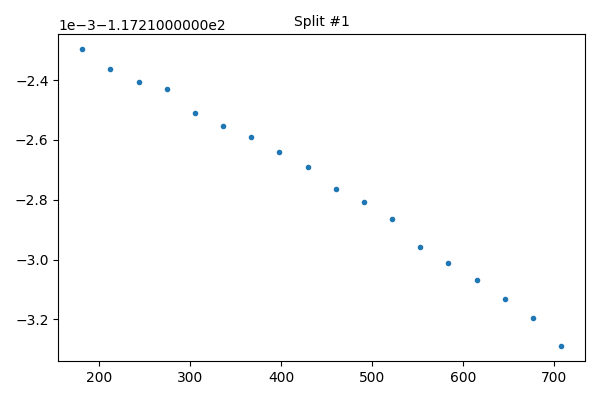

In [21]:
fig=plt.figure(figsize=(6,4))
subfignum = len(rec_split_times)
for idx, split_time in enumerate(rec_split_times):
    min_time = rec_split_times[idx]

    if idx == (len(rec_split_times) - 1):
        max_time = np.Inf
    else:
        max_time = rec_split_times[idx+1]
        
    split_barcodes = data_barcodes[np.where((data_barcode_times > min_time) * (data_barcode_times < max_time))[0]]
    syncinds = np.isin(sync_codes, split_barcodes)
    eeginds = np.isin(data_barcodes, sync_codes[syncinds])
    overlapping_sync_times = sync_times[syncinds]
    overlapping_data_times = data_barcode_times[eeginds]
    
    ax=plt.subplot(1, subfignum, idx+1)
    ax.plot(overlapping_data_times, overlapping_sync_times - overlapping_data_times, '.')
    ax.set_title('Split #%d' % (idx+1))

fig.tight_layout()

### Load original timestamps

In [22]:
original_timestamps = np.load(os.path.join(os.path.dirname(aligned_timestamps_path), data_samples_filename))

In [23]:
print(original_timestamps[0:15])
print(original_timestamps[-5:])

[3640908 3640909 3640910 3640911 3640912 3640913 3640914 3640915 3640916
 3640917 3640918 3640919 3640920 3640921 3640922]
[21687307 21687308 21687309 21687310 21687311]


In [24]:
otsdiff = np.diff(original_timestamps)
print(np.sum(otsdiff > 1))
# print(np.nonzero(otsdiff > 1)[0])
print(otsdiff[np.nonzero(otsdiff > 1)[0]][0:10])

0
[]


In [25]:
### Fix for missing timestamps ###
if 'Rhythm' in rec_system: # this is EEG
    apmemmap = np.memmap(cont_file, dtype='int16', mode='r')
    apmemmap = apmemmap.reshape((int(apmemmap.size/exp.ephys_params['EEG']['num_chs']), exp.ephys_params['EEG']['num_chs']))
    if original_timestamps.shape[0] < apmemmap.shape[0]:
        print('There are timestamps missing...')
        original_timestamps = np.arange(original_timestamps[0], original_timestamps[0] + apmemmap.shape[0])
        print(apmemmap.shape)
        print(original_timestamps.shape)
    elif original_timestamps.shape[0] > apmemmap.shape[0]:
        print('There are too many timestamps???')
elif 'Neuropix' in rec_system and '100.0' in rec_system: # this is AP
    apmemmap = np.memmap(cont_file, dtype='int16', mode='r')
    apmemmap = apmemmap.reshape((int(apmemmap.size/exp.ephys_params[probe]['num_chs']), exp.ephys_params[probe]['num_chs']))
    if original_timestamps.shape[0] < apmemmap.shape[0]:
        print('There are timestamps missing...')
        original_timestamps = np.arange(original_timestamps[0], original_timestamps[0] + apmemmap.shape[0])
        print(apmemmap.shape)
        print(original_timestamps.shape)
    elif original_timestamps.shape[0] > apmemmap.shape[0]:
        print('There are too many timestamps???')

### Loop through breaks in recording (rec_split_times) and create new timestamps

In [26]:
aligned_timestamps = []
for idx, split_time in enumerate(rec_split_times):
    if idx == 0: # in case the EEG timestamps do not begin at 0
        min_sample = original_timestamps[idx]
        min_time = min_sample/sample_rate
    else:
        min_time = rec_split_times[idx]
        min_sample = int(min_time*sample_rate)

    if idx == (len(rec_split_times) - 1):
        max_sample = original_timestamps[-1] # in case the EEG timestamps do not begin at 0
        max_time = max_sample/sample_rate
    else:
        max_time = rec_split_times[idx+1]
        max_sample = int(max_time*sample_rate)

    # this finds the barcodes from this split that are common to the sync_ and data_barcodes
    split_barcodes = np.array(data_barcodes)[
        np.where((data_barcode_times > min_time) * (data_barcode_times < max_time))[0]
    ]
    syncinds = np.isin(sync_codes, split_barcodes)
    eeginds = np.isin(data_barcodes, sync_codes[syncinds])
    overlapping_sync_times = sync_times[syncinds]
    overlapping_data_times = data_barcode_times[eeginds]

    barcode_inds = (overlapping_data_times*sample_rate).astype('int64')
    xts = np.arange(barcode_inds[0], barcode_inds[-1]+1, 1)
    midts = np.interp(xts, barcode_inds, overlapping_sync_times)

    # fit a line to first/last 10 barcodes; this will error if # barcodes in split is less than 10
    n_fit = 5
    slope1, intercept1, r1, p1, stderr1 = st.linregress(
        overlapping_data_times[0:n_fit], overlapping_sync_times[0:n_fit]
    )
    begts = np.arange(min_sample, barcode_inds[0])*(slope1/sample_rate) + intercept1

    slope2, intercept2, r2, p2, stderr2 = st.linregress(
        overlapping_data_times[-n_fit:], overlapping_sync_times[-n_fit:]
    )

    # endts = np.arange(barcode_inds[-1]+1, max_sample+1, 1)*(slope2/sample_rate) + intercept2 # OLD METHOD
    endts = np.arange(1, max_sample-barcode_inds[-1]+1, 1)*(slope2/sample_rate) + midts[-1]

    aligned_timestamps = np.concatenate((aligned_timestamps, begts, midts, endts))

In [27]:
print(aligned_timestamps[-5:])

[605.69690933 605.69694266 605.69697599 605.69700933 605.69704266]


#### Sanity check

In [28]:
if len(aligned_timestamps) == len(original_timestamps):
    print('Wahooo, same length!')
else:
    print('Uh oh...?')

Wahooo, same length!


In [29]:
if (aligned_timestamps > 12000).sum() == 0:
    print('All looks good, no crazy high timestamps')
else:
    print((aligned_timestamps > 12000).sum())

All looks good, no crazy high timestamps


In [30]:
if np.all(aligned_timestamps[1:] >= aligned_timestamps[:-1], axis=0): # should be TRUE!!! for only-increasing arrays (like timestamps should be)
    print('Good to go, timestamps are only increasing')

Good to go, timestamps are only increasing


In [31]:
if np.any(aligned_timestamps[:-1] >= aligned_timestamps[1:], axis=0): # should be TRUE!!! for only-increasing arrays (like timestamps should be)
    print('Aligned timestamps are not increasing.')

### Check offsets now

<IPython.core.display.Javascript object>


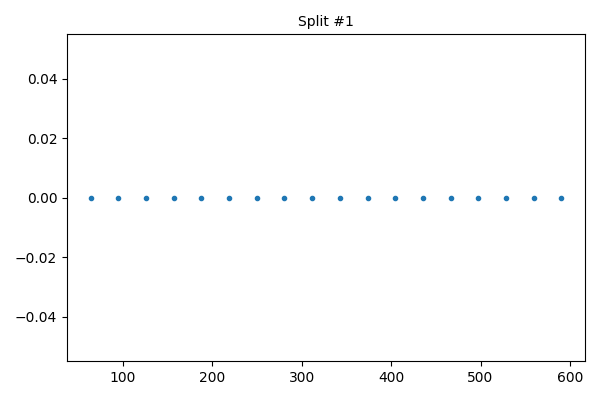

In [32]:
fig=plt.figure(figsize=(6,4))
subfignum = len(rec_split_times)
for idx, split_time in enumerate(rec_split_times):
    min_time = rec_split_times[idx]

    if idx == (len(rec_split_times) - 1):
        max_time = np.Inf
    else:
        max_time = rec_split_times[idx+1]
        
    split_barcodes = np.array(data_barcodes)[np.where((data_barcode_times > min_time) * (data_barcode_times < max_time))[0]]
    syncinds = np.isin(sync_codes, split_barcodes)
    eeginds = np.isin(data_barcodes, sync_codes[syncinds])
    overlapping_sync_times = sync_times[syncinds]
    overlapping_data_times = data_barcode_times[eeginds]
    new_data_times = aligned_timestamps[(overlapping_data_times*sample_rate).astype('int64') - original_timestamps[0]]
    # something is wrong with above line...
    
    ax=plt.subplot(1,subfignum,idx+1)
    ax.plot(new_data_times,overlapping_sync_times-new_data_times,'.')
    ax.set_title('Split #%d' % (idx+1))

fig.tight_layout()

### Used to use AP timestamps to align LFP

In [33]:
lfp_original_timestamps = np.load(os.path.join(os.path.dirname(lfp_aligned_timestamps_path), data_samples_filename))
print(len(lfp_original_timestamps))
print(lfp_original_timestamps[0:10])
print(lfp_original_timestamps[-5:])

1503931
[303345 303346 303347 303348 303349 303350 303351 303352 303353 303354]
[1807271 1807272 1807273 1807274 1807275]


In [34]:
12*303345

3640140

In [76]:
print(np.sum(np.diff(lfp_original_timestamps)>1))

0


In [46]:
if lfp_original_timestamps[0] != 0:
    print('LFP timestamps do not begin at zero')
    ap_match_inds = np.squeeze(np.in1d(original_timestamps, lfp_original_timestamps*12).nonzero())
    aligned_lfp = aligned_timestamps[ap_match_inds]
    print(len(aligned_lfp))
    if len(aligned_lfp) != len(lfp_original_timestamps):
        print('Uh oh...?')
        lfp_missing_inds = np.in1d(lfp_original_timestamps*12, original_timestamps, invert=True).nonzero()[0]
#         print(lfp_missing_inds)
        if lfp_missing_inds[0] == len(aligned_lfp):
            print('Missing timestamps are at the end of the recording.')
            missing_ts = (np.arange(1, len(lfp_missing_inds)+1) / exp.ephys_params[probe]['lfp_sample_rate']) + aligned_lfp[-1]
            aligned_lfp = np.concatenate((aligned_lfp, missing_ts))
        elif lfp_missing_inds[0] == 0:
            print('Missing timestamps are at the beginning of the recording.')
            missing_ts = -(np.arange(len(lfp_missing_inds), 0, -1) / exp.ephys_params[probe]['lfp_sample_rate']) + aligned_lfp[0]
            aligned_lfp = np.concatenate((missing_ts, aligned_lfp))

LFP timestamps do not begin at zero
1503867
Uh oh...?
Missing timestamps are at the beginning of the recording.


In [47]:
print(aligned_lfp[0:5])
print(aligned_lfp[-5:])

[4.12579273 4.12619273 4.12659273 4.12699273 4.12739273]
[605.695076   605.695476   605.695876   605.69627599 605.69667599]


In [48]:
print(len(aligned_lfp))
print(len(lfp_original_timestamps))

1503931
1503931


In [49]:
if len(aligned_lfp) == len(lfp_original_timestamps):
    print('Wahooo, same length!')
else:
    print('Uh oh...?')

Wahooo, same length!


In [50]:
if (aligned_lfp > 12000).sum() == 0:
    print('All looks good, no crazy high timestamps')
else:
    print((aligned_timestamps > 12000).sum())

All looks good, no crazy high timestamps


In [51]:
if np.all(aligned_lfp[1:] >= aligned_lfp[:-1], axis=0): # should be TRUE!!! for only-increasing arrays (like timestamps should be)
    print('Good to go, timestamps are only increasing')

Good to go, timestamps are only increasing


In [52]:
np.diff(aligned_timestamps[0:10])

array([3.33332802e-05, 3.33332802e-05, 3.33332802e-05, 3.33332802e-05,
       3.33332802e-05, 3.33332802e-05, 3.33332802e-05, 3.33332802e-05,
       3.33332802e-05])

#### All looks good, now save.

In [28]:
np.save(aligned_timestamps_path, aligned_timestamps, allow_pickle=False)

In [53]:
np.save(lfp_aligned_timestamps_path, aligned_lfp, allow_pickle=False)

### Align spike times - FIX

In [19]:
APmaster_time = np.load(exp.ephys_params[probe]['ap_timestamps'])
spike_times = np.load(exp.ephys_params[probe]['spike_times'].replace('_master_clock', ''))
print(APmaster_time.shape)
print(spike_times.shape)

(15105549,)
(728419,)


In [20]:
if spike_times[-1] > APmaster_time.shape[0]:
    print('There are extra spike times??')
    spikes_to_remove = np.where(spike_times > APmaster_time.shape[0])[0]
    print(spikes_to_remove)

There are extra spike times??
[728418]


In [21]:
## Load other files to remove extra spikes from ##
spike_clusters = np.load(exp.ephys_params[probe]['spike_clusters'])
print(spike_clusters.shape)
file_loc = os.path.dirname(exp.ephys_params[probe]['spike_times'])
spike_templates = np.load(os.path.join(file_loc, 'spike_templates.npy'))
print(spike_templates.shape)
amplitudes = np.load(os.path.join(file_loc, 'amplitudes.npy'))
print(amplitudes.shape)
pc_features = np.load(os.path.join(file_loc, 'pc_features.npy'))
print(pc_features.shape)

(728419,)
(728419, 1)
(728419, 1)
(728419, 3, 32)


In [22]:
## remove offending spiketime ##
spike_times = np.delete(spike_times, spikes_to_remove, 0)
spike_clusters = np.delete(spike_clusters, spikes_to_remove, 0)
spike_templates = np.delete(spike_templates, spikes_to_remove, 0)
amplitudes = np.delete(amplitudes, spikes_to_remove, 0)
pc_features = np.delete(pc_features, spikes_to_remove, 0)
print(pc_features.shape)

(728418, 3, 32)


In [23]:
## save all files ##
np.save(os.path.join(file_loc, 'spike_times.npy'), spike_times)
np.save(exp.ephys_params[probe]['spike_clusters'], spike_clusters)
np.save(os.path.join(file_loc, 'spike_templates.npy'), spike_templates)
np.save(os.path.join(file_loc, 'amplitudes.npy'), amplitudes)
np.save(os.path.join(file_loc, 'pc_features.npy'), pc_features)

### Original file declarations, pre-OE 0.6.0